# Imports

In [1]:
import arviz as az
from scipy.stats import gaussian_kde  # Used for estimating posterior modes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cmdstanpy
from cmdstanpy import cmdstan_path, CmdStanModel
cmdstanpy.install_cmdstan()

from tqdm.notebook import tqdm

Installing CmdStan version: 2.31.0
Install directory: C:\Users\Achille\.cmdstan
CmdStan version 2.31.0 already installed


# Import data

In [2]:
#Load and prepare the covariates, location dummies and housing prices
#For both training and test sets
housing_training_df = pd.read_csv('../data/training_set.csv')
housing_training_df.dropna(inplace = True)

housing_test_df = pd.read_csv('../data/test_set.csv')
housing_test_df.dropna(inplace = True)
#-----------------------------------------------------------------------------------------

#Y
#-----------------------------------------------------------------------------------------
housing_prices_training = housing_training_df['median_hou']
housing_prices_test =     housing_test_df['median_hou'] 
#-----------------------------------------------------------------------------------------

#X
#-----------------------------------------------------------------------------------------
covariate_columns = ['avg_room', 'avg_bedr', 'population',
                     'households', 'median_inc', 'housing_me'] #'ocean_prox'
        
housing_covariates_training = housing_training_df[covariate_columns]
housing_covariates_test =     housing_test_df[covariate_columns] 

#Non-spatial X
non_spatial_covariates = ['avg_bedr', 'population', 'households',
                          'median_inc', 'housing_me']

housing_non_spatial_covariates_training = housing_training_df[non_spatial_covariates]
housing_non_spatial_covariates_test = housing_test_df[non_spatial_covariates]

#Spatial X
spatial_covariates = ['avg_room']

housing_spatial_covariates_training = housing_training_df[spatial_covariates]
housing_spatial_covariates_test = housing_test_df[spatial_covariates]
#-----------------------------------------------------------------------------------------

#Location dummies
#-----------------------------------------------------------------------------------------
location_dummies_training = housing_training_df.loc[:, "Alameda":"Yuba":1]
location_dummies_test =     housing_test_df.loc[:, "Alameda":"Yuba":1]

county_idx_training = np.argmax(location_dummies_training.to_numpy(), axis=1) + 1
county_idx_test = np.argmax(location_dummies_test.to_numpy(), axis=1) + 1
#-----------------------------------------------------------------------------------------

#Ocean dummies
#-----------------------------------------------------------------------------------------
ocean_dummies_training = housing_training_df.loc[:,"<1H OCEAN":"NEAR OCEAN":1]
ocean_dummies_test =     housing_test_df.loc[:,"<1H OCEAN":"NEAR OCEAN":1]
#-----------------------------------------------------------------------------------------

#Turn the data into numpy
#-----------------------------------------------------------------------------------------
ocean_dummies_training = ocean_dummies_training.to_numpy()
location_dummies_training = location_dummies_training.to_numpy()
housing_covariates_training = housing_covariates_training.to_numpy()
housing_prices_training = housing_prices_training.to_numpy()

ocean_dummies_test = ocean_dummies_test.to_numpy()
location_dummies_test = location_dummies_test.to_numpy()
housing_covariates_test = housing_covariates_test.to_numpy()
housing_prices_test = housing_prices_test.to_numpy()

housing_non_spatial_covariates_training = housing_non_spatial_covariates_training.to_numpy()
housing_spatial_covariates_training = housing_spatial_covariates_training.to_numpy()

housing_spatial_covariates_training = housing_spatial_covariates_training.reshape(
    (housing_spatial_covariates_training.shape[0],)
)

housing_non_spatial_covariates_test = housing_non_spatial_covariates_test.to_numpy()
housing_spatial_covariates_test = housing_spatial_covariates_test.to_numpy()

housing_spatial_covariates_test = housing_spatial_covariates_test.reshape(
    (housing_spatial_covariates_test.shape[0],)
)

#Have to make sure that no housing price = 0, therefore add a small buffer
housing_prices_training += 10**(-7) #+ np.abs(housing_prices_training.min())
housing_prices_test += 10**(-7) #+ np.abs(housing_prices_test.min())

def unnormalize(prices):
  return prices * 484101.0 + 14999.0

#Load proximity_matrix from Utils
proximity_matrix = pd.read_csv('../data/W_kernel.csv', delimiter=',')
proximity_matrix = proximity_matrix.to_numpy()

"""# to make the prior on spatial dependence proper we introduce the spatial dependence parameter e
e = 0.99
proximity_matrix = neighbour_matrix * e"""
print(proximity_matrix.shape)

(58, 58)


# Load models

The MCMC sampled chains corresponding to each model are available via a link on the `gammas.md` file at the root of the repository.

They come in two shapes:
- Directories containing one or several csv files corresponding to the one of several MCMC chains
- `.pkl` representing either `CmdStanPy` or `ArviZ` object

For CSV files:
```{python}
import cmdstanpy
import arviz as az

# Import as stan object
cms_object = cmdstanpy.from_csv("[directory containing only the csv files OR unique csv file]")

# Convert to arviz for analysis
az_object = az.from_cmdstanpy(cms_object)
```

For pkl files (serialized python objects):
```{python}
import cmdstanpy
import arviz as az
import joblib

# Load object using joblib
cms_object = joblib.load("path_to_pkl_file")

# Convert to arviz for analysis
az_object = az.from_cmdstanpy(cms_object)
```

In [4]:
import joblib

In [5]:
simple_glm = cmdstanpy.from_csv("../mcmc_chains/simple_GLM/classic_reg-20230205183557_1.csv")
hierarchical = joblib.load("../mcmc_chains/hierarchical/cms_hierarchical_gammas.pkl")
simple_car = cmdstanpy.from_csv("../mcmc_chains/simple_CAR/simple_car.csv")
full_car = cmdstanpy.from_csv("../mcmc_chains/full_car/spatial_reg-20230212162704.csv")

12:25:43 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 iterations at max treedepth (0.1%)
	Use function "diagnose()" to see further information.
12:26:37 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 126 iterations at max treedepth (12.6%)
	Use function "diagnose()" to see further information.


In [6]:
glm_az = az.from_cmdstanpy(simple_glm)
hier_az = az.from_cmdstanpy(hierarchical)
simple_car_az = az.from_cmdstanpy(simple_car)
full_car_az = az.from_cmdstanpy(full_car)

# Predictive performance metrics

#### Function declarations

In [7]:
def calc_max_pdf_mode(data, precision=100):
    distribution = gaussian_kde(data)
    x_domain = np.linspace(min(data), max(data), precision)
    y_pdf = distribution.pdf(x_domain)
    i = np.argmax(y_pdf)
    return x_domain[i]

In [8]:
def get_county_indices(housing_df):
  county_names = housing_df.loc[:,'Alameda':'Yuba'].columns
  county_indices = [housing_df.index[housing_df[name]==1] for name in county_names]
  return county_indices, county_names

training_county_indices, county_names = get_county_indices(housing_training_df)
county_names = county_names.to_list()
training_county_masks = []
for county in range(58):
    training_county_masks.append(training_county_indices[county].to_numpy())
    
    
test_county_indices, _ = get_county_indices(housing_test_df)
test_county_masks = []
for county in range(58):
    test_county_masks.append(test_county_indices[county].to_numpy())

In [9]:
def get_param_estimates(az_fit, model_type, estimate='mean'):
    if estimate == 'mean':
        func = np.mean
    elif estimate == 'mode':
        func = calc_max_pdf_mode
    else:
        print("Estimate: ['mean', 'mode']")
        return None

    if model_type == "Simple_GLM":
        regression_parameters = np.zeros(6)
        for i in range(6):
            regression_parameters[i] = func(az_fit.posterior.regression_parameters[0, :, i])

        ocean_parameters = np.zeros(5)
        for i in range(5):
            ocean_parameters[i] = func(az_fit.posterior.ocean_parameters[0, :, i])

        return regression_parameters, ocean_parameters

    elif model_type == "Hierarchical":
        gammas = np.zeros((58, 6))
        for i in tqdm(range(58)):
            for j in range(6):
                gammas[i,j] =  func(az_fit.posterior.gamma[0, :, i, j])

        deltas = np.zeros(5)
        for i in range(5):
            deltas[i] = func(az_fit.posterior.delta[0, :, i])
                
        return gammas, deltas
        
    elif model_type == "Simple_CAR":
        betas = np.zeros(6)
        for i in range(6):
            betas[i] = func(az_fit.posterior.regression_parameters[0, :, i])

        deltas = np.zeros(5)
        for i in range(5):
            deltas[i] = func(az_fit.posterior.ocean_parameters[0, :, i])

        phi = np.zeros(58)
        for i in tqdm(range(58)):
            phi[i] = func(az_fit.posterior.phi[0, :, i])

        return betas, phi, deltas

    elif model_type == "Full_CAR":
        non_spa = np.zeros(5)
        for i in range(5):
            non_spa[i] = func(az_fit.posterior.non_spatial_regression_parameters[0, :, i])

        avg_room_params = np.zeros(58)
        for i in tqdm(range(58)):
            avg_room_params[i] = func(az_fit.posterior.avg_room_regression_parameters[0, :, i])
        
        phi = np.zeros(58)
        for i in tqdm(range(58)):
            phi[i] = func(az_fit.posterior.phi[0, :, i])

        ocean_parameters = np.zeros(5)
        for i in range(5):
            ocean_parameters[i] = func(az_fit.posterior.ocean_parameters[0, :, i])

        return non_spa, avg_room_params, phi, ocean_parameters
    
    else:
        print("Model types: ['Simple_GLM', 'Hierarchical', 'Simple_CAR', 'Full_CAR']")
        return None

def get_preds(params, model_type, X, ocean_dummies=None, location_dummies=None, avg_room=None, non_spatial_X=None, county_masks=None):
    if model_type == "Simple_GLM":
        betas, deltas = params
        return unnormalize(np.exp(X @ betas + ocean_dummies @ deltas))

    elif model_type == "Hierarchical":
        gammas, deltas = params
        
        preds = np.zeros(X.shape[0])
        for i, county_mask in enumerate(county_masks):
            preds[county_mask] = np.exp(X[county_mask] @ gammas[i] + ocean_dummies[county_mask] @ deltas)

        return unnormalize(preds)

    elif model_type == "Simple_CAR":
        betas, phi, deltas = params
        return unnormalize(np.exp(X @ betas + location_dummies @ phi + ocean_dummies @ deltas))

    elif model_type == "Full_CAR":
        non_spatial_regression_parameters, \
        avg_room_regression_parameters, \
        phi, \
        ocean_parameters = params
        return unnormalize(np.exp(
            non_spatial_X @ non_spatial_regression_parameters + 
            np.multiply(avg_room, (location_dummies @ avg_room_regression_parameters)) +
            location_dummies @ phi +
            ocean_dummies @ ocean_parameters
        ))

    else:
        print("Model types: ['Simple_GLM', 'Hierarchical', 'Simple_CAR', 'Full_CAR']")
        return None

#### Compute estimates and preds

In [10]:
glm_mode_params = get_param_estimates(glm_az, model_type='Simple_GLM', estimate='mode')
glm_mean_params = get_param_estimates(glm_az, model_type='Simple_GLM', estimate='mean')

In [11]:
hier_mode_params = get_param_estimates(hier_az, model_type='Hierarchical', estimate='mode')
hier_mean_params = get_param_estimates(hier_az, model_type='Hierarchical', estimate='mean')

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [12]:
simple_car_mode_params = get_param_estimates(simple_car_az, model_type='Simple_CAR', estimate='mode')
simple_car_mean_params = get_param_estimates(simple_car_az, model_type='Simple_CAR', estimate='mean')

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [13]:
full_car_mode_params = get_param_estimates(full_car_az, model_type='Full_CAR', estimate='mode')
full_car_mean_params = get_param_estimates(full_car_az, model_type='Full_CAR', estimate='mean')

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [14]:
# Mean - train
glm_mean_train_preds = get_preds(
    params=glm_mean_params,
    model_type="Simple_GLM",
    X=housing_covariates_training,
    ocean_dummies=ocean_dummies_training
)
hier_mean_train_preds = get_preds(
    params=hier_mean_params,
    model_type="Hierarchical",
    X=housing_covariates_training,
    ocean_dummies=ocean_dummies_training,
    county_masks=training_county_masks
)
simple_car_mean_train_preds = get_preds(
    params=simple_car_mean_params,
    model_type="Simple_CAR",
    X=housing_covariates_training,
    ocean_dummies=ocean_dummies_training,
    location_dummies=location_dummies_training,
    avg_room=housing_spatial_covariates_training,
    non_spatial_X=housing_non_spatial_covariates_training,
    county_masks=training_county_masks
)
full_car_mean_train_preds = get_preds(
    params=full_car_mean_params,
    model_type="Full_CAR",
    X=housing_covariates_training,
    ocean_dummies=ocean_dummies_training,
    location_dummies=location_dummies_training,
    avg_room=housing_spatial_covariates_training,
    non_spatial_X=housing_non_spatial_covariates_training,
    county_masks=training_county_masks
)

In [15]:
# Mode - train
glm_mode_train_preds = get_preds(
    params=glm_mean_params,
    model_type="Simple_GLM",
    X=housing_covariates_training,
    ocean_dummies=ocean_dummies_training
)
hier_mode_train_preds = get_preds(
    params=hier_mode_params,
    model_type="Hierarchical",
    X=housing_covariates_training,
    ocean_dummies=ocean_dummies_training,
    county_masks=training_county_masks
)
simple_car_mode_train_preds = get_preds(
    params=simple_car_mode_params,
    model_type="Simple_CAR",
    X=housing_covariates_training,
    ocean_dummies=ocean_dummies_training,
    location_dummies=location_dummies_training,
    avg_room=housing_spatial_covariates_training,
    non_spatial_X=housing_non_spatial_covariates_training,
    county_masks=training_county_masks
)
full_car_mode_train_preds = get_preds(
    params=full_car_mode_params,
    model_type="Full_CAR",
    X=housing_covariates_training,
    ocean_dummies=ocean_dummies_training,
    location_dummies=location_dummies_training,
    avg_room=housing_spatial_covariates_training,
    non_spatial_X=housing_non_spatial_covariates_training,
    county_masks=training_county_masks
)

In [16]:
# Mean - test
glm_mean_test_preds = get_preds(
    params=glm_mean_params,
    model_type="Simple_GLM",
    X=housing_covariates_test,
    ocean_dummies=ocean_dummies_test
)
hier_mean_test_preds = get_preds(
    params=hier_mean_params,
    model_type="Hierarchical",
    X=housing_covariates_test,
    ocean_dummies=ocean_dummies_test,
    county_masks=test_county_masks
)
simple_car_mean_test_preds = get_preds(
    params=simple_car_mean_params,
    model_type="Simple_CAR",
    X=housing_covariates_test,
    ocean_dummies=ocean_dummies_test,
    location_dummies=location_dummies_test,
    avg_room=housing_spatial_covariates_test,
    non_spatial_X=housing_non_spatial_covariates_test,
    county_masks=test_county_masks
)
full_car_mean_test_preds = get_preds(
    params=full_car_mean_params,
    model_type="Full_CAR",
    X=housing_covariates_test,
    ocean_dummies=ocean_dummies_test,
    location_dummies=location_dummies_test,
    avg_room=housing_spatial_covariates_test,
    non_spatial_X=housing_non_spatial_covariates_test,
    county_masks=test_county_masks
)

In [17]:
# Mode - test
glm_mode_test_preds = get_preds(
    params=glm_mean_params,
    model_type="Simple_GLM",
    X=housing_covariates_test,
    ocean_dummies=ocean_dummies_test
)
hier_mode_test_preds = get_preds(
    params=hier_mode_params,
    model_type="Hierarchical",
    X=housing_covariates_test,
    ocean_dummies=ocean_dummies_test,
    county_masks=test_county_masks
)
simple_car_mode_test_preds = get_preds(
    params=simple_car_mode_params,
    model_type="Simple_CAR",
    X=housing_covariates_test,
    ocean_dummies=ocean_dummies_test,
    location_dummies=location_dummies_test,
    avg_room=housing_spatial_covariates_test,
    non_spatial_X=housing_non_spatial_covariates_test,
    county_masks=test_county_masks
)
full_car_mode_test_preds = get_preds(
    params=full_car_mode_params,
    model_type="Full_CAR",
    X=housing_covariates_test,
    ocean_dummies=ocean_dummies_test,
    location_dummies=location_dummies_test,
    avg_room=housing_spatial_covariates_test,
    non_spatial_X=housing_non_spatial_covariates_test,
    county_masks=test_county_masks
)

## Predicted house values distribution

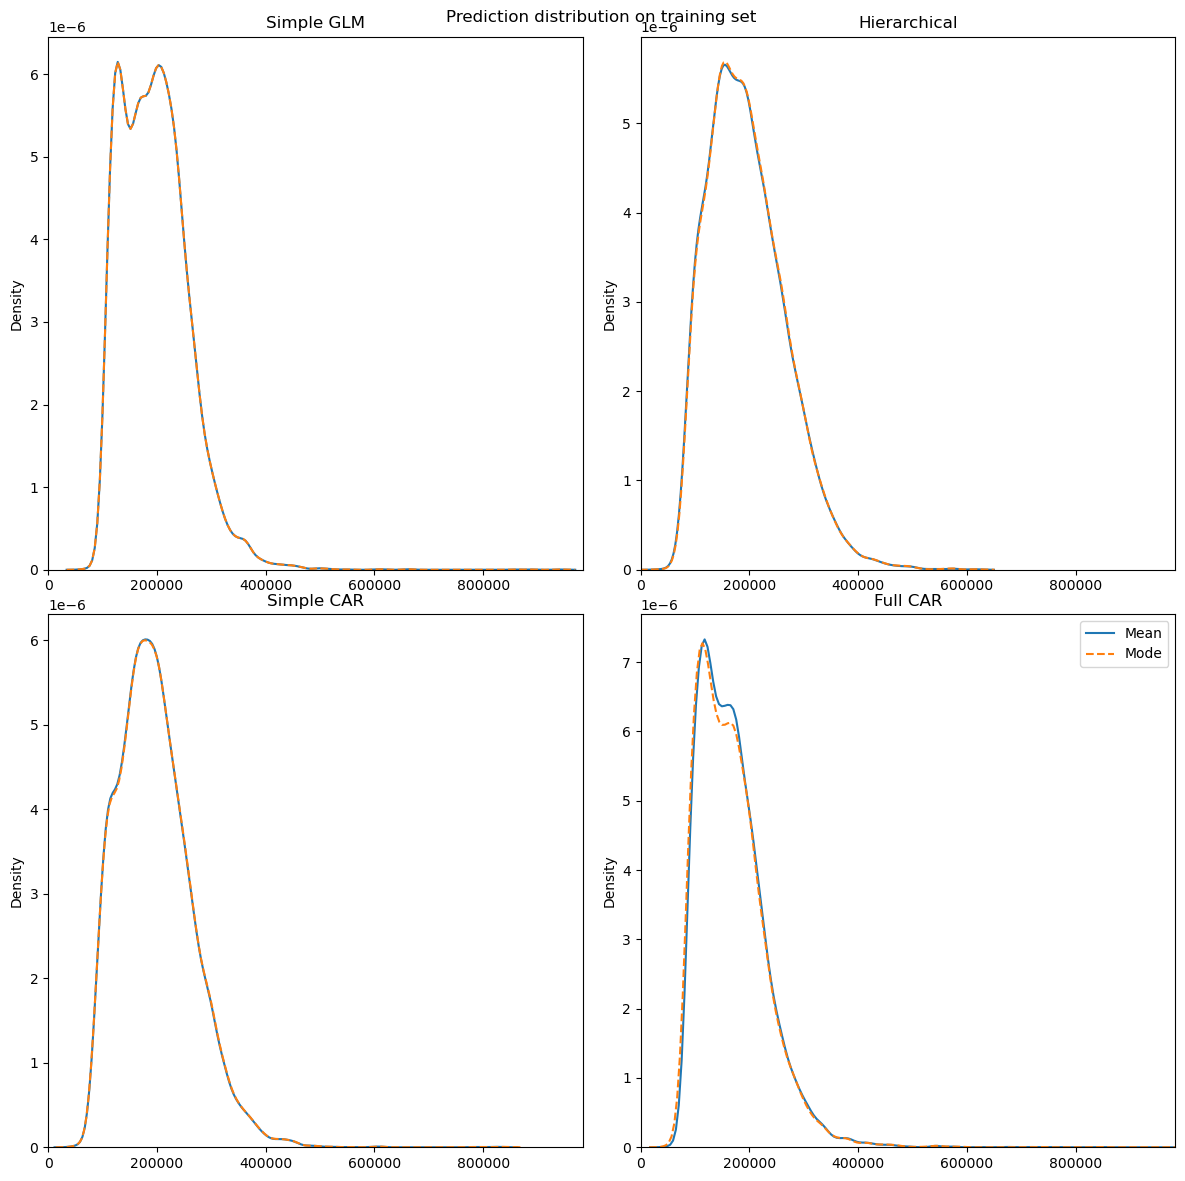

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Prediction distribution on training set")
fig.tight_layout()

for i in range(2):
    for j in range(2):
        axs[i,j].set_xlim(0,unnormalize(2))

axs[0,0].set_title("Simple GLM")
sns.kdeplot(glm_mean_train_preds, ax=axs[0,0], label="Mean")
sns.kdeplot(glm_mode_train_preds, linestyle='--', ax=axs[0,0], label="Mode")

axs[0,1].set_title("Hierarchical")
sns.kdeplot(hier_mean_train_preds, ax=axs[0,1], label="Mean")
sns.kdeplot(hier_mode_train_preds, linestyle='--', ax=axs[0,1], label="Mode")

axs[1,0].set_title("Simple CAR")
sns.kdeplot(simple_car_mean_train_preds, ax=axs[1,0], label="Mean")
sns.kdeplot(simple_car_mode_train_preds, linestyle='--', ax=axs[1,0], label="Mode")

axs[1,1].set_title("Full CAR")
sns.kdeplot(full_car_mean_train_preds, ax=axs[1,1], label="Mean")
sns.kdeplot(full_car_mode_train_preds, linestyle='--', ax=axs[1,1], label="Mode")

plt.legend()
plt.show()

We can see that there is little to no difference in the prediction. However, computing the mode is much more costly - in our implementation at least - because we have to compute the kernel density of the MCMC samples for each parameter.

#### train vs test

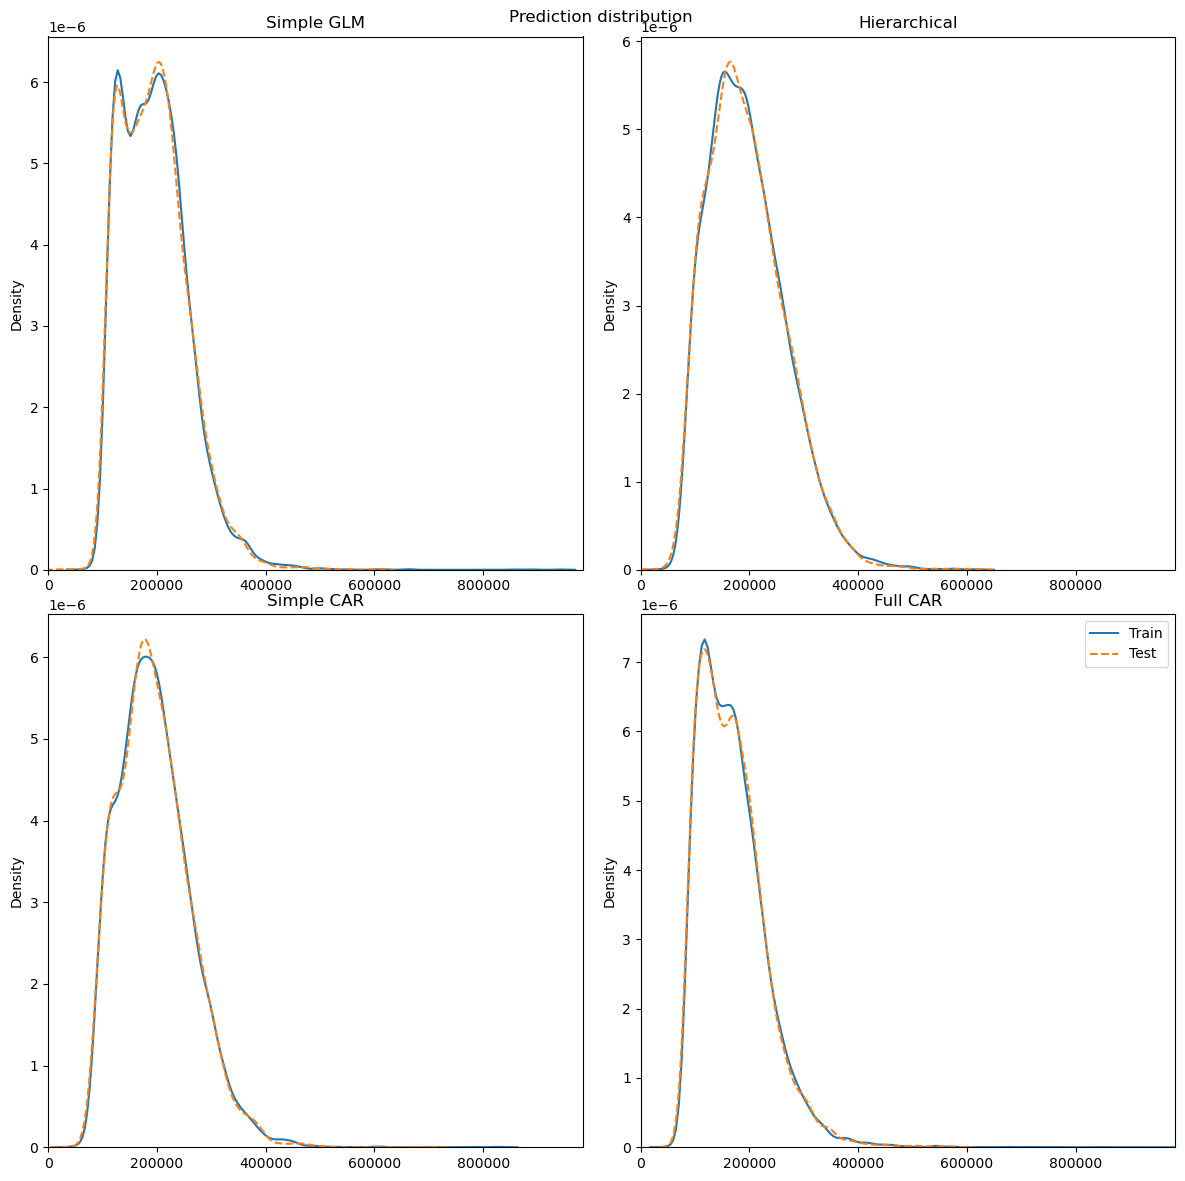

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Prediction distribution")
fig.tight_layout()

for i in range(2):
    for j in range(2):
        axs[i,j].set_xlim(0,unnormalize(2))

axs[0,0].set_title("Simple GLM")
sns.kdeplot(glm_mean_train_preds, ax=axs[0,0], label="Train")
sns.kdeplot(glm_mean_test_preds, linestyle='--', ax=axs[0,0], label="Test")

axs[0,1].set_title("Hierarchical")
sns.kdeplot(hier_mean_train_preds, ax=axs[0,1], label="Train")
sns.kdeplot(hier_mean_test_preds, linestyle='--', ax=axs[0,1], label="Test")

axs[1,0].set_title("Simple CAR")
sns.kdeplot(simple_car_mean_train_preds, ax=axs[1,0], label="Train")
sns.kdeplot(simple_car_mean_test_preds, linestyle='--', ax=axs[1,0], label="Test")

axs[1,1].set_title("Full CAR")
sns.kdeplot(full_car_mean_train_preds, ax=axs[1,1], label="Train")
sns.kdeplot(full_car_mean_test_preds, linestyle='--', ax=axs[1,1], label="Test")

plt.legend()
plt.show()

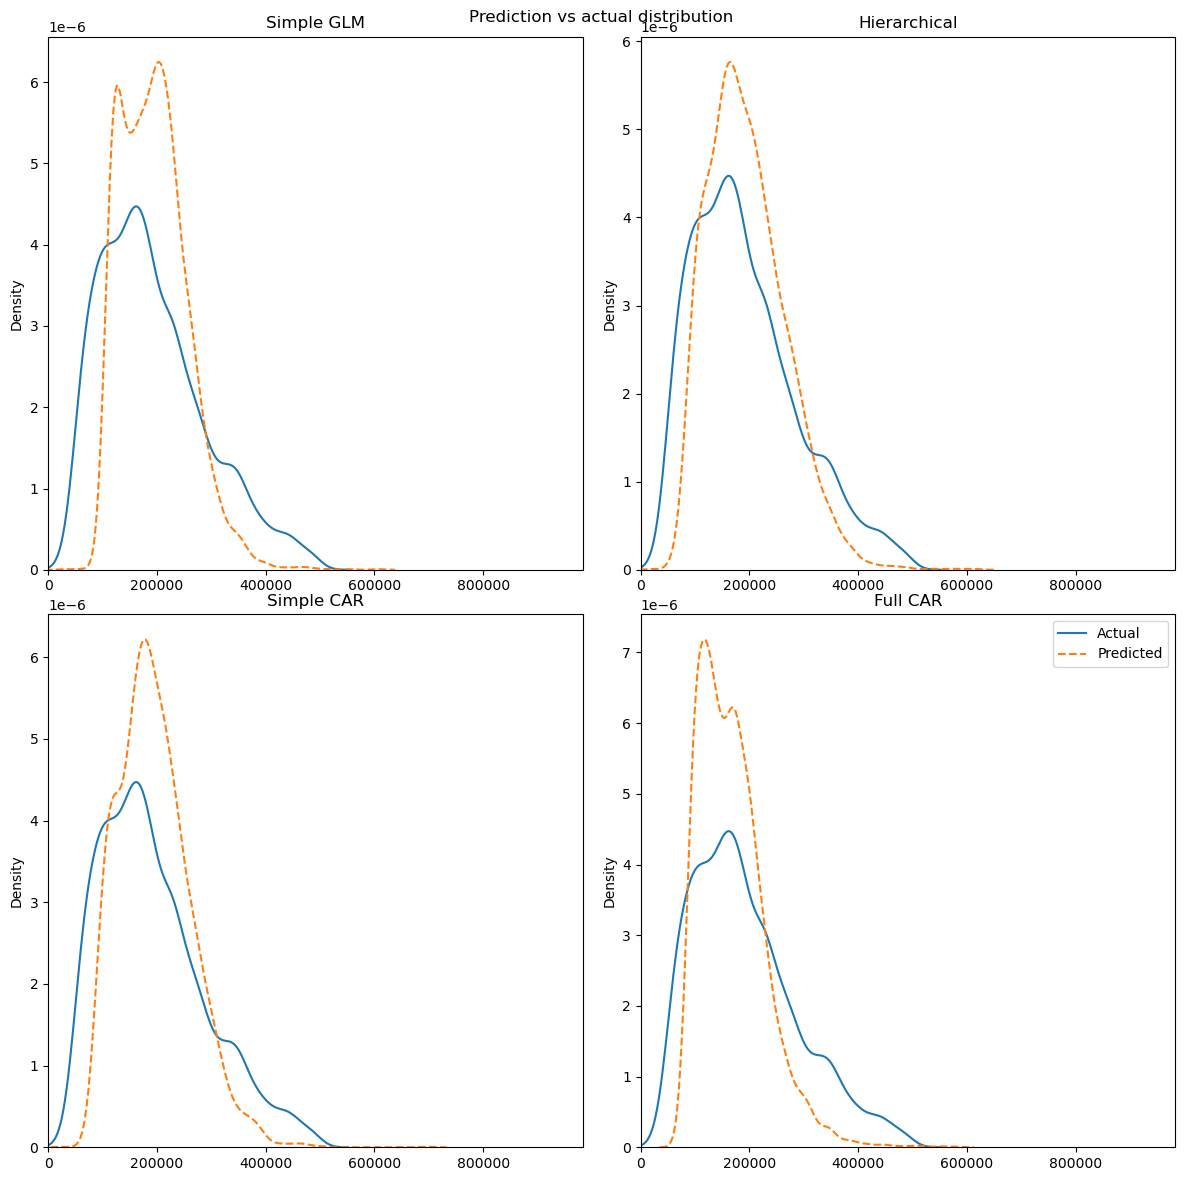

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Prediction vs actual distribution")
fig.tight_layout()

for i in range(2):
    for j in range(2):
        axs[i,j].set_xlim(0,unnormalize(2))

axs[0,0].set_title("Simple GLM")
sns.kdeplot(unnormalize(housing_prices_test), ax=axs[0,0], label="Actual")
sns.kdeplot(glm_mean_test_preds, linestyle='--', ax=axs[0,0], label="Predicted")

axs[0,1].set_title("Hierarchical")
sns.kdeplot(unnormalize(housing_prices_test), ax=axs[0,1], label="Actual")
sns.kdeplot(hier_mean_test_preds, linestyle='--', ax=axs[0,1], label="Predicted")

axs[1,0].set_title("Simple CAR")
sns.kdeplot(unnormalize(housing_prices_test), ax=axs[1,0], label="Actual")
sns.kdeplot(simple_car_mean_test_preds, linestyle='--', ax=axs[1,0], label="Predicted")

axs[1,1].set_title("Full CAR")
sns.kdeplot(unnormalize(housing_prices_test), ax=axs[1,1], label="Actual")
sns.kdeplot(full_car_mean_test_preds, linestyle='--', ax=axs[1,1], label="Predicted")

plt.legend()
plt.savefig("posterior_pred_test_vs_actual.png")

#### county-wise distribution

In [20]:
def get_county_mask(county, set='training'):
    county_idx = county_names.index(county)
    if set == 'training':
        county_masks = training_county_masks
    elif set == 'test':
        county_masks = test_county_masks
    else:
        print("Set should be 'training' or 'test'")
        return None

    return county_masks[county_idx]

In [32]:
counties_mean = np.zeros(58)
for i in range(58):
    counties_mean[i] = np.mean(hier_mean_train_preds[training_county_masks[i]])

sorted_county_names = np.array(county_names)[np.argsort(counties_mean)]

print(sorted_county_names)

['Glenn' 'Trinity' 'Modoc' 'Siskiyou' 'Kings' 'Tehama' 'Yuba' 'Sierra'
 'Lassen' 'Imperial' 'Kern' 'Tulare' 'Madera' 'Colusa' 'Del Norte'
 'Fresno' 'Butte' 'Humboldt' 'Shasta' 'Sutter' 'Lake' 'Inyo' 'Merced'
 'Plumas' 'Alpine' 'Calaveras' 'Mariposa' 'Amador' 'Tuolumne'
 'San Joaquin' 'Mendocino' 'San Bernardino' 'Yolo' 'Stanislaus'
 'Sacramento' 'Riverside' 'Solano' 'El Dorado' 'Nevada' 'Mono' 'Placer'
 'Napa' 'San Diego' 'San Benito' 'Contra Costa' 'Alameda' 'Sonoma'
 'San Luis Obispo' 'Los Angeles' 'Monterey' 'Santa Barbara' 'Santa Cruz'
 'Orange' 'Ventura' 'Santa Clara' 'San Francisco' 'San Mateo' 'Marin']


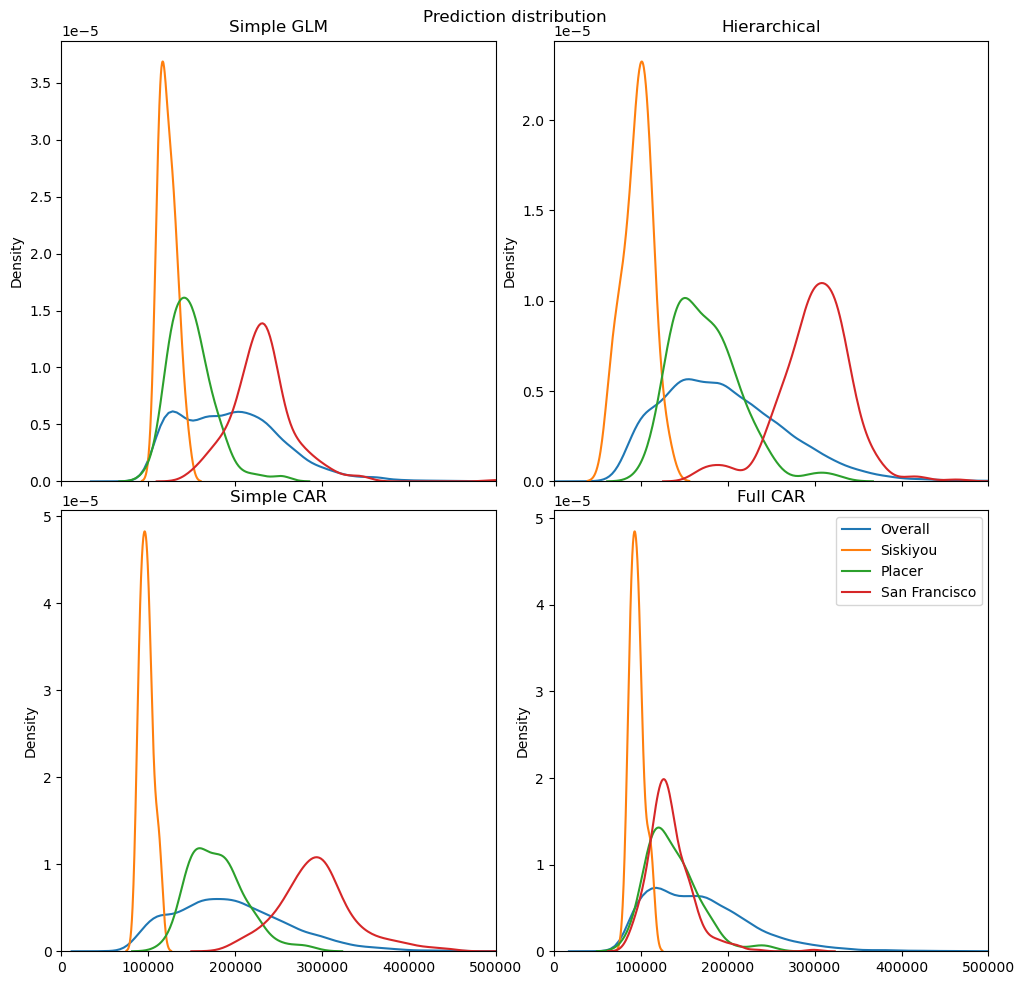

In [40]:
studied_counties = ["Siskiyou", "Placer", "San Francisco"]

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True)
fig.suptitle("Prediction distribution")
fig.tight_layout()
axs[0,0].set_xlim(0, 5e5)

axs[0,0].set_title("Simple GLM")
sns.kdeplot(glm_mean_train_preds, ax=axs[0,0], label="Overall")
for county in studied_counties:
    sns.kdeplot(glm_mean_train_preds[get_county_mask(county)], ax=axs[0,0], label=county)

axs[0,1].set_title("Hierarchical")
sns.kdeplot(hier_mean_train_preds, ax=axs[0,1], label="Overall")
for county in studied_counties:
    sns.kdeplot(hier_mean_train_preds[get_county_mask(county)], ax=axs[0,1], label=county)

axs[1,0].set_title("Simple CAR")
sns.kdeplot(simple_car_mean_train_preds, ax=axs[1,0], label="Overall")
for county in studied_counties:
    sns.kdeplot(simple_car_mean_train_preds[get_county_mask(county)], ax=axs[1,0], label=county)

axs[1,1].set_title("Full CAR")
sns.kdeplot(full_car_mean_train_preds, ax=axs[1,1], label="Overall")
for county in studied_counties:
    sns.kdeplot(full_car_mean_train_preds[get_county_mask(county)], ax=axs[1,1], label=county)

plt.legend()
plt.show()

### Mean Square Error

In [22]:
from sklearn.metrics import mean_squared_error

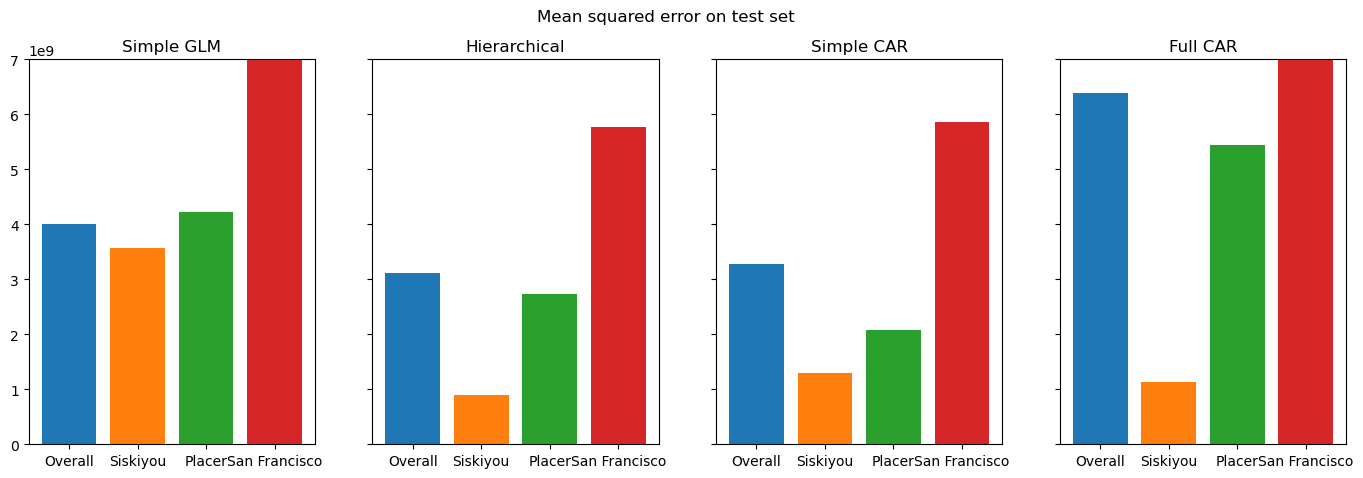

In [53]:
studied_counties = ["Siskiyou", "Placer", "San Francisco"]

categories = ["Overall"] + studied_counties
default_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

fig, axs = plt.subplots(1, 4, sharey=True, figsize=(17,5))
fig.suptitle("Mean squared error on test set")
axs = axs.flatten()
axs[0].set_ylim(0, 7e9)

mses = [mean_squared_error(glm_mean_test_preds, unnormalize(housing_prices_test))]
for county in studied_counties:
    county_mask = get_county_mask(county, set="test")
    mses.append(mean_squared_error(glm_mean_test_preds[county_mask], unnormalize(housing_prices_test[county_mask])))
axs[0].bar(categories, mses, color=default_colors)
axs[0].set_title("Simple GLM")

mses = [mean_squared_error(hier_mean_test_preds, unnormalize(housing_prices_test))]
for county in studied_counties:
    county_mask = get_county_mask(county, set="test")
    mses.append(mean_squared_error(hier_mean_test_preds[county_mask], unnormalize(housing_prices_test[county_mask])))
axs[1].bar(categories, mses, color=default_colors)
axs[1].set_title("Hierarchical")

mses = [mean_squared_error(simple_car_mean_test_preds, unnormalize(housing_prices_test))]
for county in studied_counties:
    county_mask = get_county_mask(county, set="test")
    mses.append(mean_squared_error(simple_car_mean_test_preds[county_mask], unnormalize(housing_prices_test[county_mask])))
axs[2].bar(categories, mses, color=default_colors)
axs[2].set_title("Simple CAR")

mses = [mean_squared_error(full_car_mean_test_preds, unnormalize(housing_prices_test))]
for county in studied_counties:
    county_mask = get_county_mask(county, set="test")
    mses.append(mean_squared_error(full_car_mean_test_preds[county_mask], unnormalize(housing_prices_test[county_mask])))
axs[3].bar(categories, mses, color=default_colors)
axs[3].set_title("Full CAR")

plt.show()

### Threshold accuracy

In [47]:
def thresh_accuracy(preds, true_y, err):
    return np.mean((np.abs(preds - true_y) / true_y) < err)

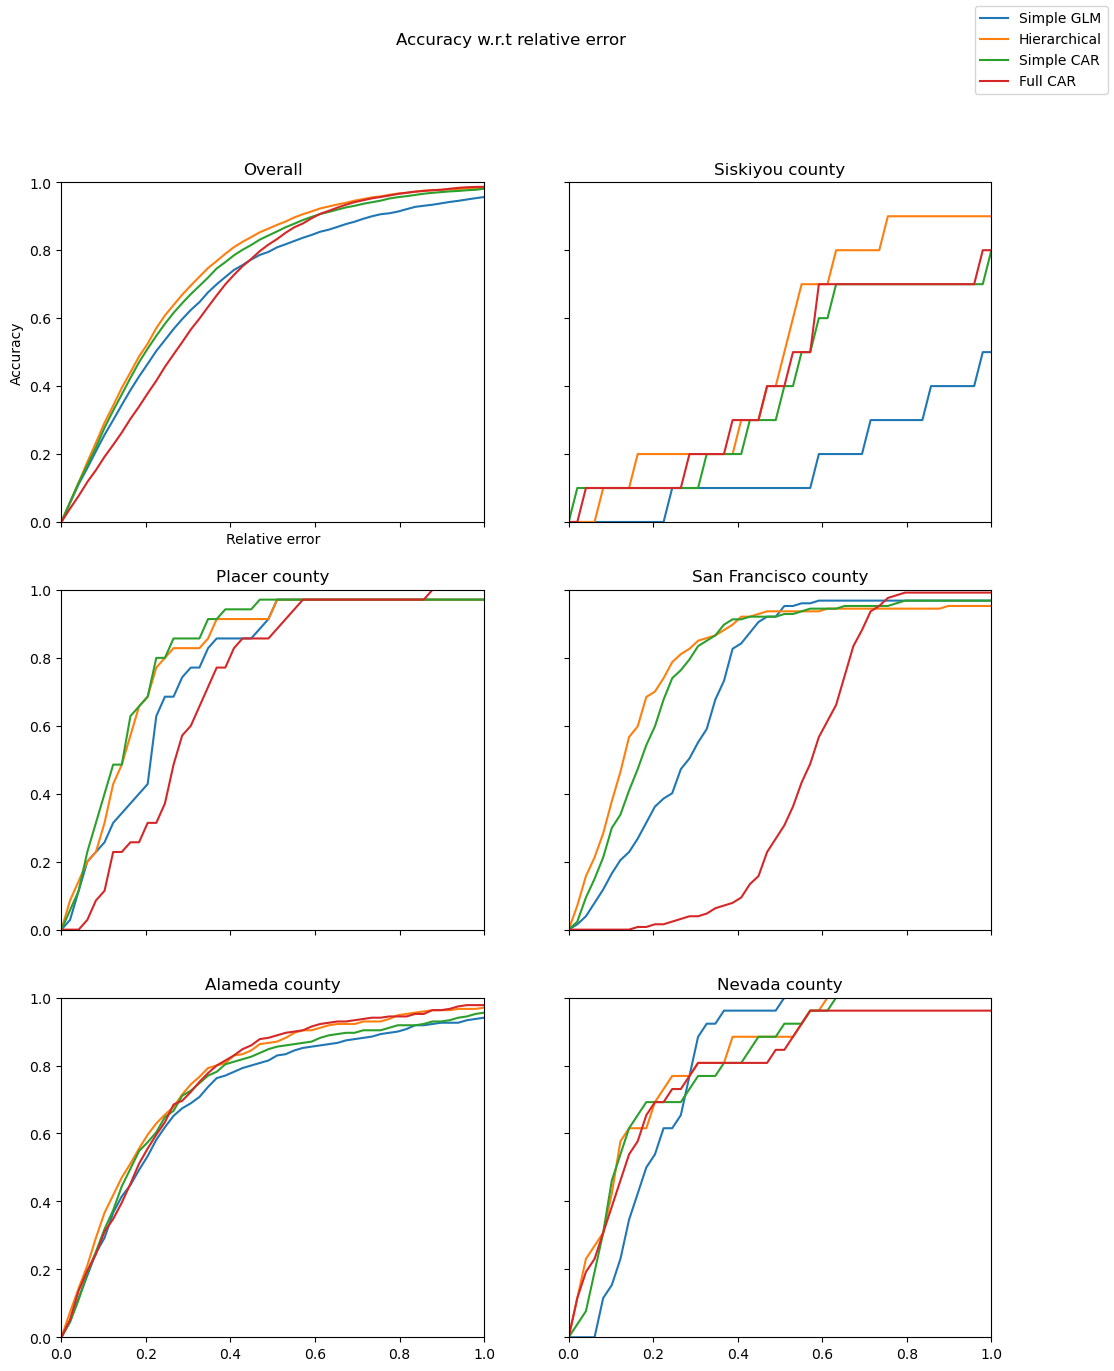

In [65]:
studied_counties = ["Siskiyou", "Placer", "San Francisco", "Alameda", "Nevada"]
precision = 50

xx = np.linspace(0, 1, precision)

fig, axs = plt.subplots(3, 2, figsize=(12, 15), sharex=True, sharey=True)
fig.suptitle("Accuracy w.r.t relative error")
axs = axs.flatten()

axs[0].set_xlabel("Relative error")
axs[0].set_ylabel("Accuracy")

axs[0].set_ylim(0,1)
axs[0].set_xlim(0,1)

axs[0].set_title("Overall")
axs[0].plot(xx, [thresh_accuracy(glm_mean_test_preds, unnormalize(housing_prices_test), x) for x in xx], label="Simple GLM")
axs[0].plot(xx, [thresh_accuracy(hier_mean_test_preds, unnormalize(housing_prices_test), x) for x in xx], label="Hierarchical")
axs[0].plot(xx, [thresh_accuracy(simple_car_mean_test_preds, unnormalize(housing_prices_test), x) for x in xx], label="Simple CAR")
axs[0].plot(xx, [thresh_accuracy(full_car_mean_test_preds, unnormalize(housing_prices_test), x) for x in xx], label="Full CAR")

for k, county in enumerate(studied_counties):
    axs[k+1].set_title(county + " county")
    axs[k+1].plot(xx, [thresh_accuracy(glm_mean_test_preds[get_county_mask(county, set='test')], unnormalize(housing_prices_test[get_county_mask(county, set='test')]), x) for x in xx])
    axs[k+1].plot(xx, [thresh_accuracy(hier_mean_test_preds[get_county_mask(county, set='test')], unnormalize(housing_prices_test[get_county_mask(county, set='test')]), x) for x in xx])
    axs[k+1].plot(xx, [thresh_accuracy(simple_car_mean_test_preds[get_county_mask(county, set='test')], unnormalize(housing_prices_test[get_county_mask(county, set='test')]), x) for x in xx])
    axs[k+1].plot(xx, [thresh_accuracy(full_car_mean_test_preds[get_county_mask(county, set='test')], unnormalize(housing_prices_test[get_county_mask(county, set='test')]), x) for x in xx])

fig.legend()
plt.show()